In [11]:
import numpy as np
import gymnasium as gym
import random
import os

import matplotlib.pyplot as plt

In [12]:
env = gym.make("FrozenLake-v1") 

In [13]:
action_size = env.action_space.n
state_size = env.observation_space.n

Qtable = np.zeros((state_size, action_size))
print(Qtable)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [14]:
def greedy_policy(Qtable, state):
    # Exploitation: take the action with the highest state, action value
    action = np.argmax(Qtable[state][:])

    return action

In [15]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    # Randomly generate a number between 0 and 1
    random_num = random.uniform(0, 1)
    # if random_num > greater than epsilon --> exploitation
    if random_num > epsilon:
        # Take the action with the highest value given a state
        # np.argmax can be useful here
        action = greedy_policy(Qtable, state)
    # else --> exploration
    else:
        action = env.action_space.sample()

    return action

In [16]:
# Training parameters
n_training_episodes = 400  # Total training episodes
learning_rate = 0.7  # Learning rate

# Evaluation parameters
n_eval_episodes = 100  # Total number of test episodes

# Environment parameters
env_id = "FrozenLake-v1"  # Name of the environment
max_steps = 99  # Max steps per episode
gamma = 0.95  # Discounting rate
eval_seed = []  # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0  # Exploration probability at start
min_epsilon = 0.05  # Minimum exploration probability
decay_rate = 0.0005  # Exponential decay rate for exploration prob

In [17]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in range(n_training_episodes):
        # Reduce epsilon (because we need less and less exploration)
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        # Reset the environment
        state, info = env.reset()
        step = 0
        terminated = False
        truncated = False

        # repeat
        for step in range(max_steps):
            # Choose the action At using epsilon greedy policy
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            # Take action At and observe Rt+1 and St+1
            # Take the action (a) and observe the outcome state(s') and reward (r)
            new_state, reward, terminated, truncated, info = env.step(action)

            # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            Qtable[state][action] = Qtable[state][action] + learning_rate * (
                reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action]
            )

            # If terminated or truncated finish the episode
            if terminated or truncated:
                break

            # Our next state is the new state
            state = new_state
    return Qtable

In [18]:
Qtable = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable)

In [19]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
    episode_rewards = []
    for episode in range(n_eval_episodes):
        if seed:
            state, info = env.reset(seed=seed[episode])
        else:
            state, info = env.reset()
        step = 0
        truncated = False
        terminated = False
        total_rewards_ep = 0

        for step in range(max_steps):
            # Take the action (index) that have the maximum expected future reward given that state
            action = greedy_policy(Q, state)
            new_state, reward, terminated, truncated, info = env.step(action)
            total_rewards_ep += reward

            if terminated or truncated:
                break
            state = new_state
        episode_rewards.append(total_rewards_ep)

    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)

    episodes = range(1, len(episode_rewards) + 1)
    
    plt.scatter(episodes, episode_rewards)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward")
    plt.title("Evaluation Results")
    plt.show()

    plt.subplot(312)
    plt.scatter(list(range(len(episode_rewards))), episode_rewards)
    plt.title('Epsilon')
    plt.ylabel('Epsilon')
    plt.xlabel('Episode')
    
    print(f"Episode: {episode + 1}, Mean Reward: {mean_reward}, Std Reward: {std_reward}")

    print('Train mean % score=', round(100 * np.mean(episode_rewards), 1))

    return mean_reward, std_reward

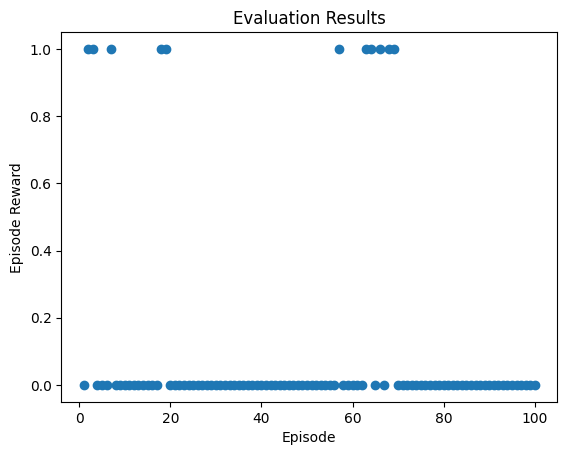

Episode: 100, Mean Reward: 0.11, Std Reward: 0.31288975694324034
Train mean % score= 11.0
Mean_reward=0.11 +/- 0.31


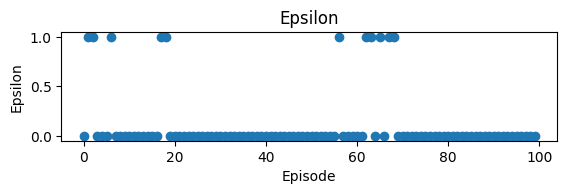

In [20]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")